# Classification of reviews


Creators:
* Kajetan Sulwiński (siemieniuk)
* Szymon Siemieniuk (ekohachi22)
* Mikołaj Marmurowicz (Mickeyo0o)

In this notebook we will try to classify the rating value based on pure text of the rating from the dataset that can be found [here](https://www.kaggle.com/datasets/prakharrathi25/google-play-store-reviews). To achieve the classification we will explore 3 sentiment analysis techniques:
* Lexicon based Approach,
* Bayesian Network Approach,
* K-nn Approach.

## Necessary imports.

In [5]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Data Preprocessing.

In reality only two columns of this data set are of interest to us thus we will drop other columns, additionally we will remove data points that do not have any values in the content column. We will also rename the columns for our purpouses and change the scores given to contain only 3 categories:
* Positive (4-5),
* Neutral (3),
* Negative (1-2).

In [2]:
df = pd.read_csv("reviews.csv")
df = df.drop(
    [
        "reviewId",
        "userName",
        "userImage",
        "reviewCreatedVersion",
        "thumbsUpCount",
        "at",
        "replyContent",
        "repliedAt",
        "sortOrder",
        "appId",
    ],
    axis=1,
)
df = df.dropna(subset=["content"])
df = df.rename(columns={"score": "Label", "content": "Translated_Review"})
replacement_dict = {
    1: "Negative",
    2: "Negative",
    3: "Neutral",
    4: "Positive",
    5: "Positive",
}
df["Label"] = df["Label"].replace(replacement_dict)
df

,Translated_Review,Label
0,I cannot open the app anymore,Negative
1,I have been begging for a refund from this app...,Negative
2,Very costly for the premium version (approx In...,Negative
3,"Used to keep me organized, but all the 2020 UP...",Negative
4,Dan Birthday Oct 28,Negative
...,...,...
12490,"I really like the planner, it helps me achieve...",Positive
12491,😁****😁,Positive
12492,Very useful apps. You must try it,Positive
12493,Would pay for this if there were even more add...,Positive


Additionally, we will perform typical text transformations, such us lowercasing, removal of punctuation, tokenization, removal of stopwords, removal of numbers, removal of special characters and lemmatization.

In [6]:
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [8]:
nltk.data.path.append('D:\\Environment\\nltk_data')

In [10]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Remove special characters and numbers using regular expression
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Removing punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

df_preprocessed = df.copy()

# Apply preprocessing to the 'Translated_Review' column
df_preprocessed['Translated_Review'] = df_preprocessed['Translated_Review'].apply(preprocess_text)
df_preprocessed

,Translated_Review,Label
0,open app anymore,Negative
1,begging refund app month nobody replying,Negative
2,costly premium version approx indian rupee per...,Negative
3,used keep organized update made mess thing cud...,Negative
4,dan birthday oct,Negative
...,...,...
12490,really like planner help achieve task goal ave...,Positive
12491,,Positive
12492,useful apps must try,Positive
12493,would pay even addition update absolutely love...,Positive


## Data Visualizations

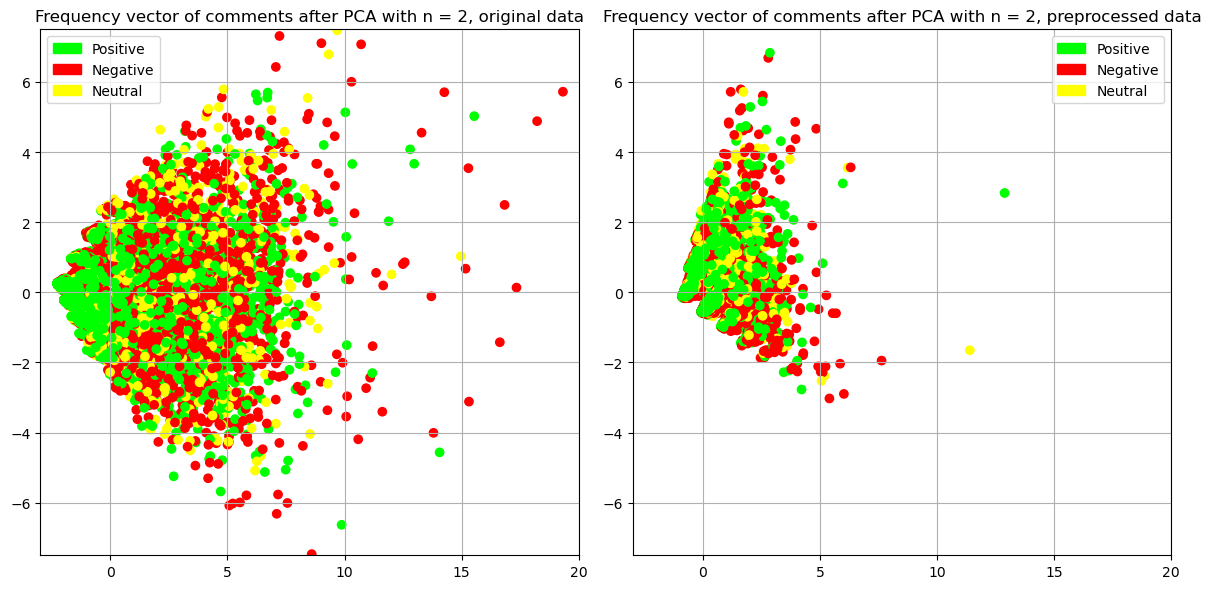

In [34]:
col_dict = {
    'Positive': '#00ff00',
    'Negative': '#ff0000',
    'Neutral': '#ffff00'
}

vectorizer = CountVectorizer()
pcaDecomposer = PCA(n_components=2)

plt.figure(figsize=(12, 6))

X = vectorizer.fit_transform(df['Translated_Review'])
X = pcaDecomposer.fit_transform(np.asarray(X.todense()))
plt.subplot(1, 2, 1)
plt.title('Frequency vector of comments after PCA with n = 2, original data')
plt.scatter(X[:, 0], X[:, 1], c=[col_dict[x] for x in df['Label']])
plt.grid()
plt.xlim(-3, 20)
plt.ylim(-7.5, 7.5)
plt.legend(handles=[mpatches.Patch(color=col_dict[key], label=key) for key in col_dict])

X = vectorizer.fit_transform(df_preprocessed['Translated_Review'])
X = pcaDecomposer.fit_transform(np.asarray(X.todense()))
plt.subplot(1, 2, 2)
plt.title('Frequency vector of comments after PCA with n = 2, preprocessed data')
plt.scatter(X[:, 0], X[:, 1], c=[col_dict[x] for x in df['Label']])
plt.grid()
plt.xlim(-3, 20)
plt.ylim(-7.5, 7.5)
plt.legend(handles=[mpatches.Patch(color=col_dict[key], label=key) for key in col_dict])

plt.tight_layout()
plt.show()

<Axes: >

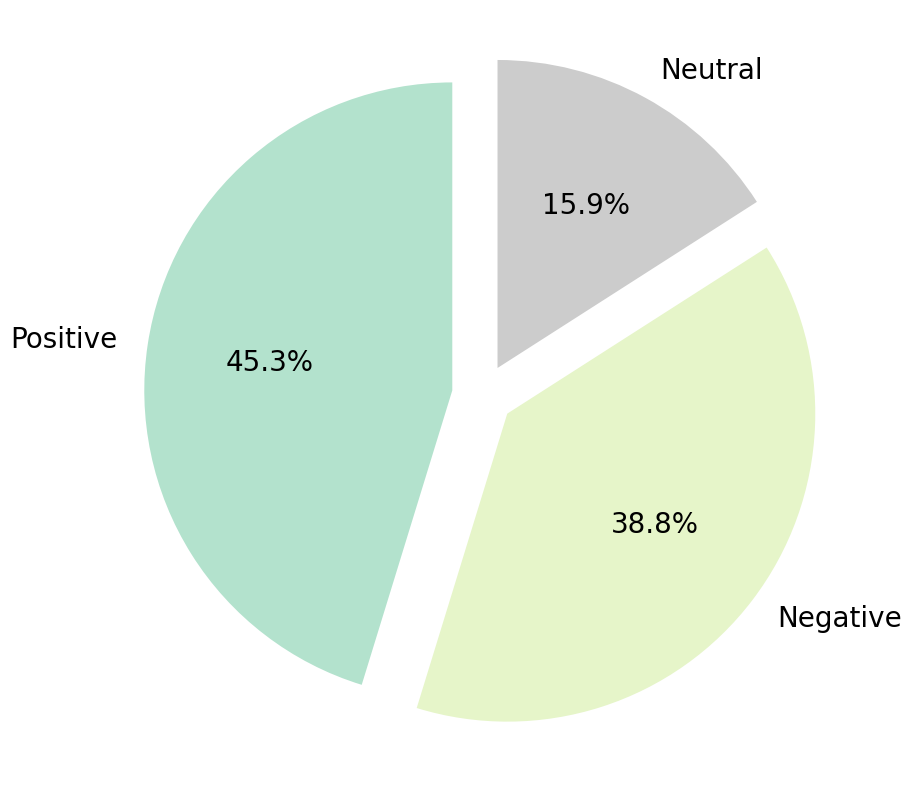

In [35]:
kwargs = dict(
    startangle = 90,
    colormap   = 'Pastel2',
    fontsize   = 20,
    explode    = (0.1,0.1,0.1),
    figsize    = (120,10),
    autopct    = '%1.1f%%',
    xlabel = '',
    ylabel = ''
)

df['Label'].value_counts().plot.pie(**kwargs)

## Lexicon based approach

This approach revolves around analyzing text sentiment by using a predefined lists of words along with their associated sentiment polarity (positive, negative, or neutral). These lists, often referred to as lexicons or dictionaries, contain words categorized based on their sentiment orientation. For given problem we analyze each threshold for the decision if the comment is negative, positive or neutral between values -0.8 and 0.8 with step 0.1.

In [38]:
analyzer = SentimentIntensityAnalyzer()

In [39]:
def classify_sentiment(review, thres_pos, thres_neg):
    scores = analyzer.polarity_scores(review)
    compound_score = scores["compound"]
    if compound_score >= thres_pos:
        return "Positive"
    elif compound_score <= thres_neg:
        return "Negative"
    else:
        return "Neutral"

In [40]:
def get_accuracies(df):
    thres_min = -0.8
    thres_max = 0.8
    step = 0.1

    y_true = df['Label']
    accuracies = pd.DataFrame({'pos': [], 'neg': [], 'acc': []})
    thres_neg = thres_min
    best_acc = 0
    best_thresholds = ()
    while thres_neg <= thres_max:
        thres_pos = thres_neg + step
        while thres_pos <= thres_max:
            y_pred = df["Translated_Review"].apply(classify_sentiment, args=(thres_pos, thres_neg))
            accuracy = accuracy_score(y_true, y_pred)
            acc_row = {'pos': thres_pos, 'neg': thres_neg, 'acc': accuracy}
            accuracies = pd.concat([accuracies.loc[:], pd.DataFrame(acc_row, index=[0])]).reset_index(drop=True)
            if accuracy > best_acc:
                best_acc = accuracy
                best_thresholds = (thres_pos, thres_neg)
            thres_pos += step
        thres_neg += step
    return accuracies, best_thresholds, best_acc

In [42]:
accuracies_org, best_thresholds_org, best_acc_org = get_accuracies(df.copy())
accuracies_preprocessed, best_thresholds_preprocessed, best_acc_preprocessed = get_accuracies(df_preprocessed.copy())
accuracies_org

,pos,neg,acc
0,-0.7,-0.8,0.470908
1,-0.6,-0.8,0.472829
2,-0.5,-0.8,0.474190
3,-0.4,-0.8,0.477551
4,-0.3,-0.8,0.481473
...,...,...,...
131,0.7,0.5,0.521729
132,0.8,0.5,0.481313
133,0.7,0.6,0.530292
134,0.8,0.6,0.489876


In [46]:
def display_acc_plot(accuracies, best_thresholds, best_acc, accuracies_p, best_thresholds_p, best_acc_p, title):
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(title)

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_xlabel('Positive Threshold')
    ax.set_ylabel('Negative Threshold')
    ax.set_title('Without Preprocessing')
    ax.plot_trisurf(accuracies['pos'], accuracies['neg'], accuracies['acc'], edgecolor='none', linewidth=0.1)
    ax.scatter(best_thresholds[0], best_thresholds[1], best_acc, c='#ff0000')
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_xlabel('Positive Threshold')
    ax.set_ylabel('Negative Threshold')
    ax.set_title('With Preprocessing')
    ax.plot_trisurf(accuracies_preprocessed['pos'], accuracies_preprocessed['neg'], accuracies_preprocessed['acc'], edgecolor='none', linewidth=0.1)
    ax.scatter(best_thresholds_preprocessed[0], best_thresholds_preprocessed[1], best_acc_preprocessed, c='#ff0000')

    plt.tight_layout()
    plt.show()

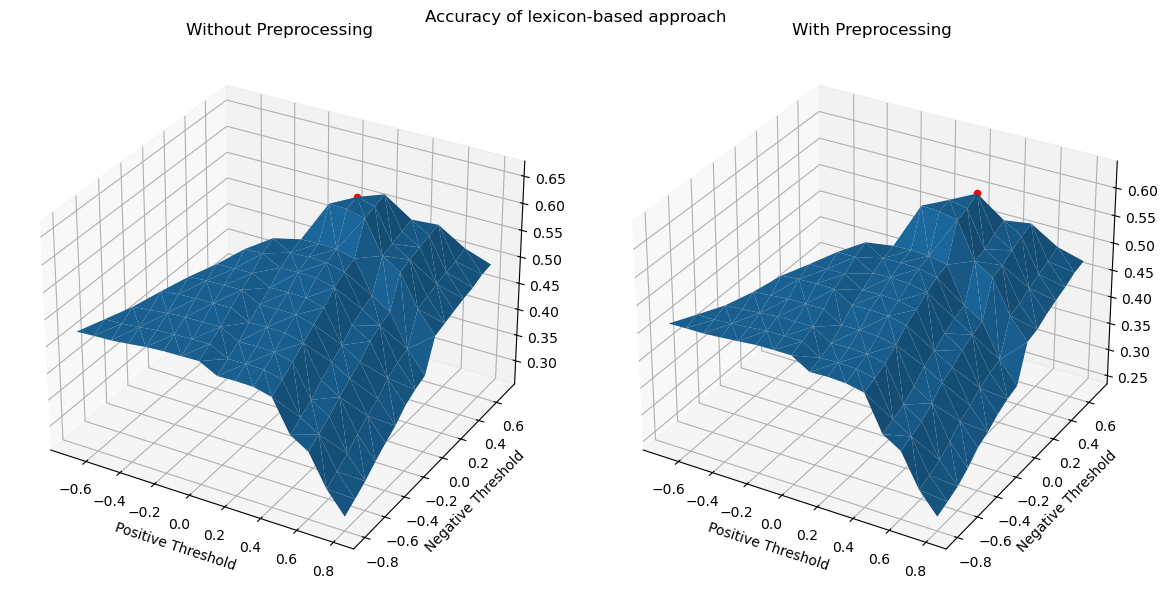

In [47]:
display_acc_plot(accuracies_org, best_thresholds_org, best_acc_org, accuracies_preprocessed, best_thresholds_preprocessed, best_acc_preprocessed, 'Accuracy of lexicon-based approach')

In [48]:
print("Thresholds for preprocessed data:")
print(f'\tNegative threshold: {best_thresholds_preprocessed[1]}, Positive threshold: {best_thresholds_preprocessed[0]}')
print("Thresholds for data without preprocessing:")
print(f'\tNegative threshold: {best_thresholds_org[1]}, Positive threshold: {best_thresholds_org[0]}')

Thresholds for preprocessed data:
	Negative threshold: 0.2999999999999999, Positive threshold: 0.3999999999999999
Thresholds for data without preprocessing:
	Negative threshold: 0.19999999999999987, Positive threshold: 0.2999999999999999


In [50]:
df["Classification"] = df["Translated_Review"].apply(classify_sentiment, args=(best_thresholds_org[0], best_thresholds_org[1]))
df_preprocessed["Classification"] = df_preprocessed["Translated_Review"].apply(classify_sentiment, args=(best_thresholds_preprocessed[0], best_thresholds_preprocessed[1]))

y_true = df["Label"]
y_pred = df["Classification"]
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average="macro")
precision = precision_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print("Results without preprocessing:")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1, "\n")

y_true = df_preprocessed["Label"]
y_pred = df_preprocessed["Classification"]
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average="macro")
precision = precision_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print("Results with preprocessing:")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1)


Results without preprocessing:
Accuracy: 0.6506602641056423
Recall: 0.525477981979117
Precision: 0.532360673628053
F1-Score: 0.5049937101130128 

Results with preprocessing:
Accuracy: 0.6218487394957983
Recall: 0.5002776902979046
Precision: 0.494389398201186
F1-Score: 0.47984579367211905


## Bayesian network

Now to use the bayesian network we will split the data into test and train sets. That means that the accuracy and other scores cannot be directly compared to the previous approach, as these models learn from the data, and provide results which are solely based on the number of provided examples and the information within them. Additionally, the lexicon based approach accuracy score is calculated on the whole set of data, while in the below methods the accuracy score is based only on a certain portion of the data.

In [51]:
X = df_preprocessed["Translated_Review"]
Y = df_preprocessed["Label"]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [52]:
bayesMultinomial = MultinomialNB()
bayesBernoulli = BernoulliNB(binarize=0.5)
bayesMultinomial.fit(X_train, Y_train)
bayesBernoulli.fit(X_train, Y_train)

BernoulliNB(binarize=0.5)

In [53]:
Y_predMulti = bayesMultinomial.predict(X_test)
Y_predBernoulli = bayesBernoulli.predict(X_test)

In [54]:
def calc_metrics(Y_test, Y_pred):
    accuracy = accuracy_score(Y_test, Y_pred)

    recall = recall_score(Y_test, Y_pred, average="macro")

    precision = precision_score(Y_test, Y_pred, average="macro")

    f1 = f1_score(Y_test, Y_pred, average="macro")

    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1-Score:", f1)

In [57]:
print('Multinomial Naive Bayes: ')
calc_metrics(Y_test, Y_predMulti)
print('Bernoulli Naive Bayes: ')
calc_metrics(Y_test, Y_predBernoulli)

Multinomial Naive Bayes: 
Accuracy: 0.7093469910371318
Recall: 0.5725944412213665
Precision: 0.5740244585441113
F1-Score: 0.5532702088185277
Bernoulli Naive Bayes: 
Accuracy: 0.6427656850192062
Recall: 0.5253869133197532
Precision: 0.5437097898090794
F1-Score: 0.5181457781042699


## k-NN

Here we once again split the data into training and testing. Additionally, we graph the accuracy dependency on the number of k nearest neighbours.

In [58]:
X = df_preprocessed["Translated_Review"]
Y = df_preprocessed["Label"].values
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [59]:
def train_KNN(X_train, Y_train):
    k_range = range(1, 21)
    accuracies = {}
    best_acc = 0
    best_k = 1
    for k in k_range:
        knn_model = KNeighborsClassifier(n_neighbors=k, metric='cosine')
        kf = KFold(n_splits=10)
        curr_accs = []
        for train, test in kf.split(X_train):
            x_loc_train = np.take(X_train, train, axis=0)
            y_loc_train = np.take(Y_train, train)
            x_loc_test = np.take(X_train, test, axis=0)
            y_loc_test = np.take(Y_train, test)
            knn_model.fit(x_loc_train, y_loc_train)
            acc = accuracy_score(y_loc_test, knn_model.predict(x_loc_test))
            curr_accs.append(acc)
        mean_acc = np.mean(curr_accs)
        accuracies[k] = mean_acc
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_k = k
    return accuracies, best_k, best_acc

In [61]:
accuracies, best_k, best_acc = train_KNN(np.asarray(X_train.todense()), Y_train)

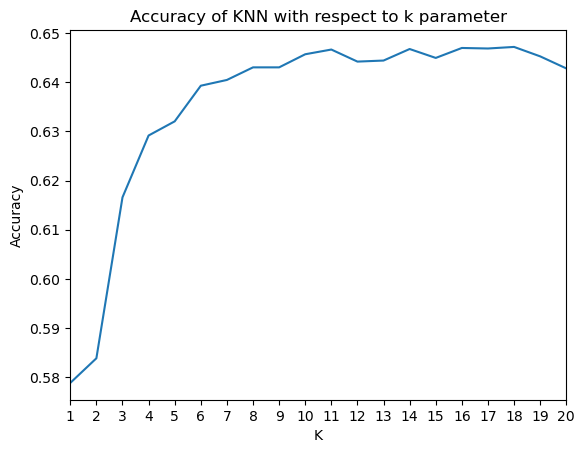

In [62]:
plt.title("Accuracy of KNN with respect to k parameter")
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.xlim(1, 20)
plt.xticks([x for x in accuracies])
plt.plot([x for x in accuracies], [accuracies[i] for i in accuracies])
plt.show()

In [63]:
print(f'Best K: {best_k}')
print(f'Best accuracy: {best_acc}')

Best K: 18
Best accuracy: 0.6472114196512482


Even though K = 18 achieves the best results, we recommend using K around 10-11, as it provides similar results, and is far less computationally complex.